/usr/local/lib/python3.10/dist-packages/albumentations/check_version.py:51: UserWarning: Error fetching version info <urlopen error [Errno -3] Temporary failure in name resolution>
  data = fetch_version_info()


Found 2052 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Found 684 validated image filenames belonging to 5 classes.
Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


65/65 ━━━━━━━━━━━━━━━━━━━━ 163s 1s/step - accuracy: 0.1911 - loss: 2.9153 - val_accuracy: 0.2120 - val_loss: 1.7405
Epoch 2/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 464ms/step - accuracy: 0.2998 - loss: 2.3698 - val_accuracy: 0.2061 - val_loss: 1.7740
Epoch 3/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 32s 480ms/step - accuracy: 0.3090 - loss: 2.3294 - val_accuracy: 0.3816 - val_loss: 1.7280
Epoch 4/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 462ms/step - accuracy: 0.3798 - loss: 2.0259 - val_accuracy: 0.3596 - val_loss: 1.7097
Epoch 5/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 465ms/step - accuracy: 0.4224 - loss: 1.9491 - val_accuracy: 0.4810 - val_loss: 1.3622
Epoch 6/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 476ms/step - accuracy: 0.4123 - loss: 1.9713 - val_accuracy: 0.4883 - val_loss: 1.5008
Epoch 7/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 464ms/step - accuracy: 0.4709 - loss: 1.6878 - val_accuracy: 0.5643 - val_loss: 1.4080
Epoch 8/20
65/65 ━━━━━━━━━━━━━━━━━━━━ 31s 467ms/step - accuracy: 0.4767 - loss: 1.7255 - val_accuracy: 0.6228 

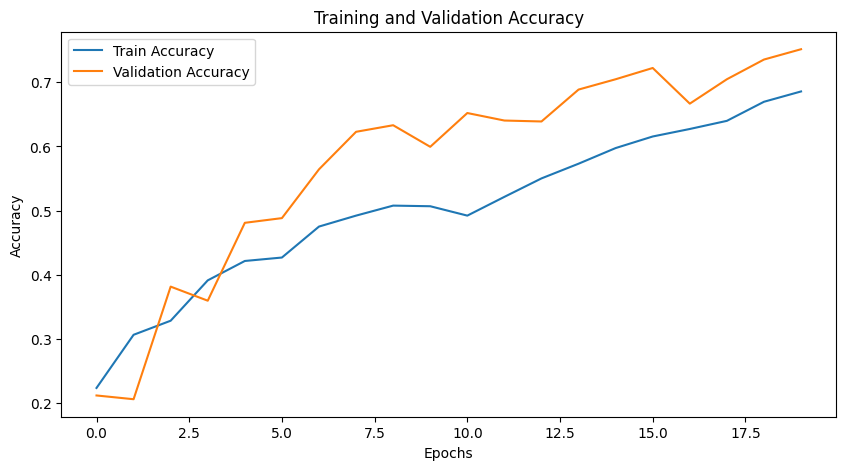

22/22 ━━━━━━━━━━━━━━━━━━━━ 14s 392ms/step


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_ranking.py:891: UserWarning: No positive class found in y_true, recall is set to one for all thresholds.
  warnings.warn(


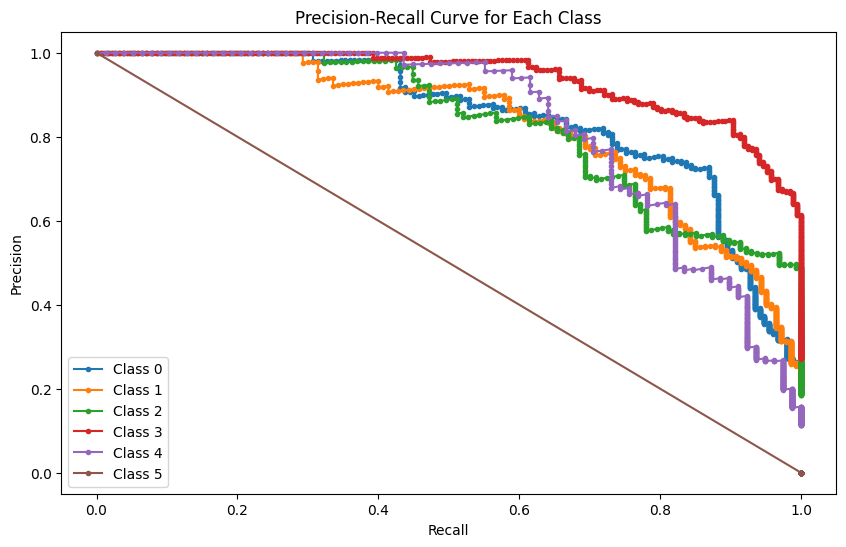

In [1]:
import os
import cv2
import numpy as np
import random
import albumentations as A
import matplotlib.pyplot as plt
import pandas as pd
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.optimizers import SGD
from sklearn.metrics import precision_recall_curve

# Disable version check for albumentations
import albumentations.core.utils
albumentations.core.utils.check_version = lambda: None

# Set dataset paths
dataset_path = "/kaggle/input/thermal-images-diseased-healthy-leaves-paddy/thermal images UL"
output_path = "/kaggle/working/expanded_dataset"
final_dataset_path = "/kaggle/working/final_processed_dataset"

# Ensure only valid labels are considered
valid_labels = {"BLB", "Blast", "healthy", "hispa", "leaf folder", "leaf spot"}

# Create necessary directories
os.makedirs(output_path, exist_ok=True)
os.makedirs(final_dataset_path, exist_ok=True)

# Define augmentations (removed problematic ElasticTransform)
augmentations = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Rotate(limit=45, p=0.5),
    A.RandomBrightnessContrast(p=0.5),
    A.GaussianBlur(p=0.3),
    A.RandomResizedCrop(height=299, width=299, scale=(0.7, 1.0), p=0.5),
    A.GridDistortion(p=0.3),
    A.ShiftScaleRotate(shift_limit=0.1, scale_limit=0.1, rotate_limit=30, p=0.5)
])

# Define image processing functions
def apply_clahe(img):
    lab = cv2.cvtColor(img, cv2.COLOR_BGR2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    l = clahe.apply(l)
    return cv2.cvtColor(cv2.merge((l, a, b)), cv2.COLOR_LAB2BGR)

def apply_filtering(img):
    return cv2.medianBlur(cv2.GaussianBlur(img, (5, 5), 0), 5)

def apply_thresholding(img):
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return cv2.cvtColor(binary, cv2.COLOR_GRAY2BGR)

def apply_morphology(img):
    kernel = np.ones((5, 5), np.uint8)
    return cv2.morphologyEx(img, cv2.MORPH_CLOSE, kernel)

# Expand dataset to 220 images per label
for label in os.listdir(dataset_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(dataset_path, label)
    save_path = os.path.join(output_path, label)
    os.makedirs(save_path, exist_ok=True)
    
    images = [os.path.join(label_path, img) for img in os.listdir(label_path)]
    
    while len(images) < 220:
        img_path = random.choice(images)
        try:
            img = cv2.imread(img_path)
            if img is None:
                continue
            augmented = augmentations(image=img)["image"]
            cv2.imwrite(os.path.join(save_path, f"aug_{len(images)}.jpg"), augmented)
            images.append(img_path)
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
            continue

# Apply Processing Techniques
for label in os.listdir(output_path):
    if label not in valid_labels:
        continue
    label_path = os.path.join(output_path, label)
    save_label_path = os.path.join(final_dataset_path, label)
    os.makedirs(save_label_path, exist_ok=True)
    
    for img_file in os.listdir(label_path):
        try:
            img_path = os.path.join(label_path, img_file)
            img = cv2.imread(img_path)
            if img is None:
                continue
            
            cv2.imwrite(os.path.join(save_label_path, f"orig_{img_file}"), img)
            cv2.imwrite(os.path.join(save_label_path, f"clahe_{img_file}"), apply_clahe(img))
            cv2.imwrite(os.path.join(save_label_path, f"filtered_{img_file}"), apply_filtering(img))
            cv2.imwrite(os.path.join(save_label_path, f"thresh_{img_file}"), apply_thresholding(img))
            cv2.imwrite(os.path.join(save_label_path, f"morph_{img_file}"), apply_morphology(img))
        except Exception as e:
            print(f"Error processing {img_file}: {e}")
            continue

# Load dataset and split into Train/Validation/Test
all_images, all_labels = [], []
label_map = {label: idx for idx, label in enumerate(valid_labels)}

for label in valid_labels:
    label_path = os.path.join(final_dataset_path, label)
    if not os.path.exists(label_path):
        continue
    for img_file in os.listdir(label_path):
        img_path = os.path.join(label_path, img_file)
        if os.path.exists(img_path):
            all_images.append(img_path)
            all_labels.append(label_map[label])

if not all_images:
    raise Exception("No valid images found in the dataset")

train_imgs, temp_imgs, train_labels, temp_labels = train_test_split(all_images, all_labels, test_size=0.4, stratify=all_labels, random_state=42)
val_imgs, test_imgs, val_labels, test_labels = train_test_split(temp_imgs, temp_labels, test_size=0.5, stratify=temp_labels, random_state=42)

# Compute class weights
class_weights = compute_class_weight("balanced", classes=np.unique(all_labels), y=all_labels)
class_weight_dict = {i: class_weights[i] for i in range(len(class_weights))}

# Convert labels to strings
train_labels = list(map(str, train_labels))
val_labels = list(map(str, val_labels))
test_labels = list(map(str, test_labels))

# Modified preprocessing for InceptionV3 with error handling
def safe_preprocessing(x):
    try:
        return tf.keras.applications.inception_v3.preprocess_input(x)
    except:
        return x / 255.0

datagen = ImageDataGenerator(preprocessing_function=safe_preprocessing)

# Data generators with error handling
train_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": train_imgs, "class": train_labels}),
    x_col="filename",
    y_col="class",
    target_size=(299, 299),
    batch_size=32,
    class_mode="sparse"
)

val_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": val_imgs, "class": val_labels}),
    x_col="filename",
    y_col="class",
    target_size=(299, 299),
    batch_size=32,
    class_mode="sparse"
)

test_gen = datagen.flow_from_dataframe(
    pd.DataFrame({"filename": test_imgs, "class": test_labels}),
    x_col="filename",
    y_col="class",
    target_size=(299, 299),
    batch_size=32,
    class_mode="sparse",
    shuffle=False
)

# Create model with random initialization since weights download is failing
base_model = InceptionV3(
    weights=None,  # Use random initialization
    include_top=False,
    input_shape=(299, 299, 3)
)

# Define model architecture
x = GlobalAveragePooling2D()(base_model.output)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
out = Dense(len(valid_labels), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)

# Compile model with reduced learning rate
model.compile(
    optimizer=SGD(learning_rate=0.0001, momentum=0.9),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Train with error handling (removed workers and use_multiprocessing arguments)
try:
    history = model.fit(
        train_gen,
        validation_data=val_gen,
        epochs=20,
        class_weight=class_weight_dict
    )

    # Evaluate model
    test_loss, test_accuracy = model.evaluate(test_gen)
    print("Final Test Accuracy:", test_accuracy)

    # Plot training history
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Training and Validation Accuracy')
    plt.show()

    # Compute and plot PR curve
    num_classes = len(valid_labels)
    y_true = tf.keras.utils.to_categorical(test_gen.classes, num_classes)
    y_probs = model.predict(test_gen)

    plt.figure(figsize=(10, 6))
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true[:, i], y_probs[:, i])
        plt.plot(recall, precision, marker='.', label=f'Class {i}')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision-Recall Curve for Each Class')
    plt.legend()
    plt.show()

except Exception as e:
    print(f"An error occurred during training: {e}")